# Goals

1. Artist Popularity Trends: Who are the most followed or popular artists? Which genres dominate Spotify?
2. Track Insights: How do explicit tracks compare with clean tracks in terms of popularity or energy?
3. Genre & Era Evolution: How have track characteristics like danceability or energy changed over time?
4. Audio Feature Correlations: What is the relationship between track popularity and Spotify’s audio features like energy or danceability?

In [4]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import seaborn as sns
pd.plotting.register_matplotlib_converters()

In [5]:
df_ar = pd.read_csv("artists.csv")
df_tr = pd.read_csv("tracks.csv")

In [6]:
print(df_ar.head())
print(df_ar.shape)
print(df_ar.columns)

                       id  followers genres  \
0  0DheY5irMjBUeLybbCUEZ2        0.0     []   
1  0DlhY15l3wsrnlfGio2bjU        5.0     []   
2  0DmRESX2JknGPQyO15yxg7        0.0     []   
3  0DmhnbHjm1qw6NCYPeZNgJ        0.0     []   
4  0Dn11fWM7vHQ3rinvWEl4E        2.0     []   

                                             name  popularity  
0  Armid & Amir Zare Pashai feat. Sara Rouzbehani           0  
1                                     ปูนา ภาวิณี           0  
2                                           Sadaa           0  
3                                       Tra'gruda           0  
4                          Ioannis Panoutsopoulos           0  
(1104349, 5)
Index(['id', 'followers', 'genres', 'name', 'popularity'], dtype='object')


In [7]:
print(df_tr.head())
print(df_tr.shape)
print(df_tr.columns)

                       id                                 name  popularity  \
0  35iwgR4jXetI318WEWsa1Q                                Carve           6   
1  021ht4sdgPcrDgSk7JTbKY  Capítulo 2.16 - Banquero Anarquista           0   
2  07A5yehtSnoedViJAZkNnc   Vivo para Quererte - Remasterizado           0   
3  08FmqUhxtyLTn6pAh6bk45        El Prisionero - Remasterizado           0   
4  08y9GfoqCWfOGsKdwojr5e                  Lady of the Evening           0   

   duration_ms  explicit              artists                  id_artists  \
0       126903         0              ['Uli']  ['45tIt06XoI0Iio4LBEVpls']   
1        98200         0  ['Fernando Pessoa']  ['14jtPCOoNZwquk5wd9DxrY']   
2       181640         0  ['Ignacio Corsini']  ['5LiOoJbxVSAMkBS2fUm3X2']   
3       176907         0  ['Ignacio Corsini']  ['5LiOoJbxVSAMkBS2fUm3X2']   
4       163080         0      ['Dick Haymes']  ['3BiJGZsyX9sJchTqcSA7Su']   

  release_date  danceability  energy  key  loudness  mode  speechine

In [8]:
df_tr.isnull().sum()

id                   0
name                71
popularity           0
duration_ms          0
explicit             0
artists              0
id_artists           0
release_date         0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
time_signature       0
dtype: int64

In [9]:
df_ar.isnull().sum()

id             0
followers     13
genres         0
name           3
popularity     0
dtype: int64

In [10]:
# Dropping unnecessary columns 

df_tr.drop(columns=['key', 'mode', 'time_signature'], inplace=True)

# Columns description 

### Tracks : 

1. id – Unique identifier for the track on Spotify (used for joining or reference).

2. name – Title of the track.

3. popularity – Popularity score ranging from 0 (least) to 100 (most popular), based on recent streams.

4. duration_ms – Duration of the track in milliseconds.

5. explicit – Indicates if the track contains explicit content:
1 = Explicit, 0 = Clean.

6. artists – Name(s) of the artist(s) who performed the track (can be multiple).

7. id_artists – Spotify IDs of the artist(s) (used to join with artist dataset).

8. release_date – Date the track was released (can be in YYYY-MM-DD, YYYY-MM, or YYYY format).

9. danceability – How suitable a track is for dancing (range: 0.0 to 1.0).
Higher = easier to dance to.

10. energy – Intensity and activity of the track (range: 0.0 to 1.0).
Higher = more energetic.

11. loudness – Loudness in decibels (dB). Lower = quieter.

12. speechiness – Presence of spoken words.
Higher values → more like talk shows, podcasts, or rap.

13. acousticness – Confidence measure of whether the track is acoustic (0.0–1.0).

14. instrumentalness – Predicts if a track contains no vocals (0.0–1.0).
Higher → more instrumental.

15. liveness – Likelihood the track was performed live.
Higher = more live audience presence.

16. valence – Positivity or happiness of the track (0.0 = sad, 1.0 = happy).

17. tempo – Estimated tempo in beats per minute (BPM).



### Artists : 

1. id – Unique identifier for the artist on Spotify.
Useful for joining with track data via id_artists.

2. followers – Total number of people following the artist on Spotify.
Indicates long-term fan engagement.

3. genres – List of genres associated with the artist (e.g., "pop", "hip hop", "rock").
Useful for analyzing genre trends or clustering.

4. name – Name of the artist or band.
Useful for filtering, display, or grouping.

5. popularity – Popularity score of the artist (0–100), based on recent streaming activity and audience engagement.

# Data Cleaning

In [11]:
# Convert release_date to datetime where possible
df_tr['release_date_clean'] = pd.to_datetime(df_tr['release_date'], errors='coerce', dayfirst=False)
df_tr['release_year'] = pd.to_datetime(df_tr['release_date'], errors='coerce').dt.year
df_tr['release_year'].sample(100)

322236    2009.0
449957    2012.0
147070    1983.0
469986    1996.0
390437    2021.0
           ...  
376776    1987.0
538445    1987.0
529420    2012.0
86525     2014.0
393814    1990.0
Name: release_year, Length: 100, dtype: float64

In [12]:
df_tr['release_year'].isna().sum()

np.int64(138591)

In [13]:
# Ensure datetime conversion
df_tr['release_year'] = pd.to_datetime(df_tr['release_date'], errors='coerce').dt.year

# Fill missing years with median (if any)
if df_tr['release_year'].notna().sum() > 0:
    median_year = int(df_tr['release_year'].median())
    df_tr['release_year'] = df_tr['release_year'].fillna(median_year)
    print(f"Filled missing release_year values with median: {median_year}")
else:
    print("No valid years found in release_date column.")

Filled missing release_year values with median: 1997


In [14]:
# convert 0 and 1 to "Clean" and "Explicit" for visuals
df_tr['explicit_label'] = df_tr['explicit'].map({0: 'Clean', 1: 'Explicit'})

In [15]:
# This grabs the first artist from the list.
df_tr['main_artist'] = df_tr['artists'].apply(lambda x: eval(x)[0] if isinstance(x, str) else x)

# This grabs the first artist_id from the list.
df_tr['main_artist_id'] = df_tr['id_artists'].apply(lambda x: eval(x)[0] if isinstance(x, str) else x)

In [16]:
df_tr['name'] = df_tr['name'].fillna('Unknown Title') # Replace missing values in the 'name' column of the track dataset with 'Unknown Title'
df_ar = df_ar[df_ar['name'].notnull()] # Remove rows from the artist dataset where the 'name' column is missing (NaN) as only 3 are missing

# Outlier Detection 

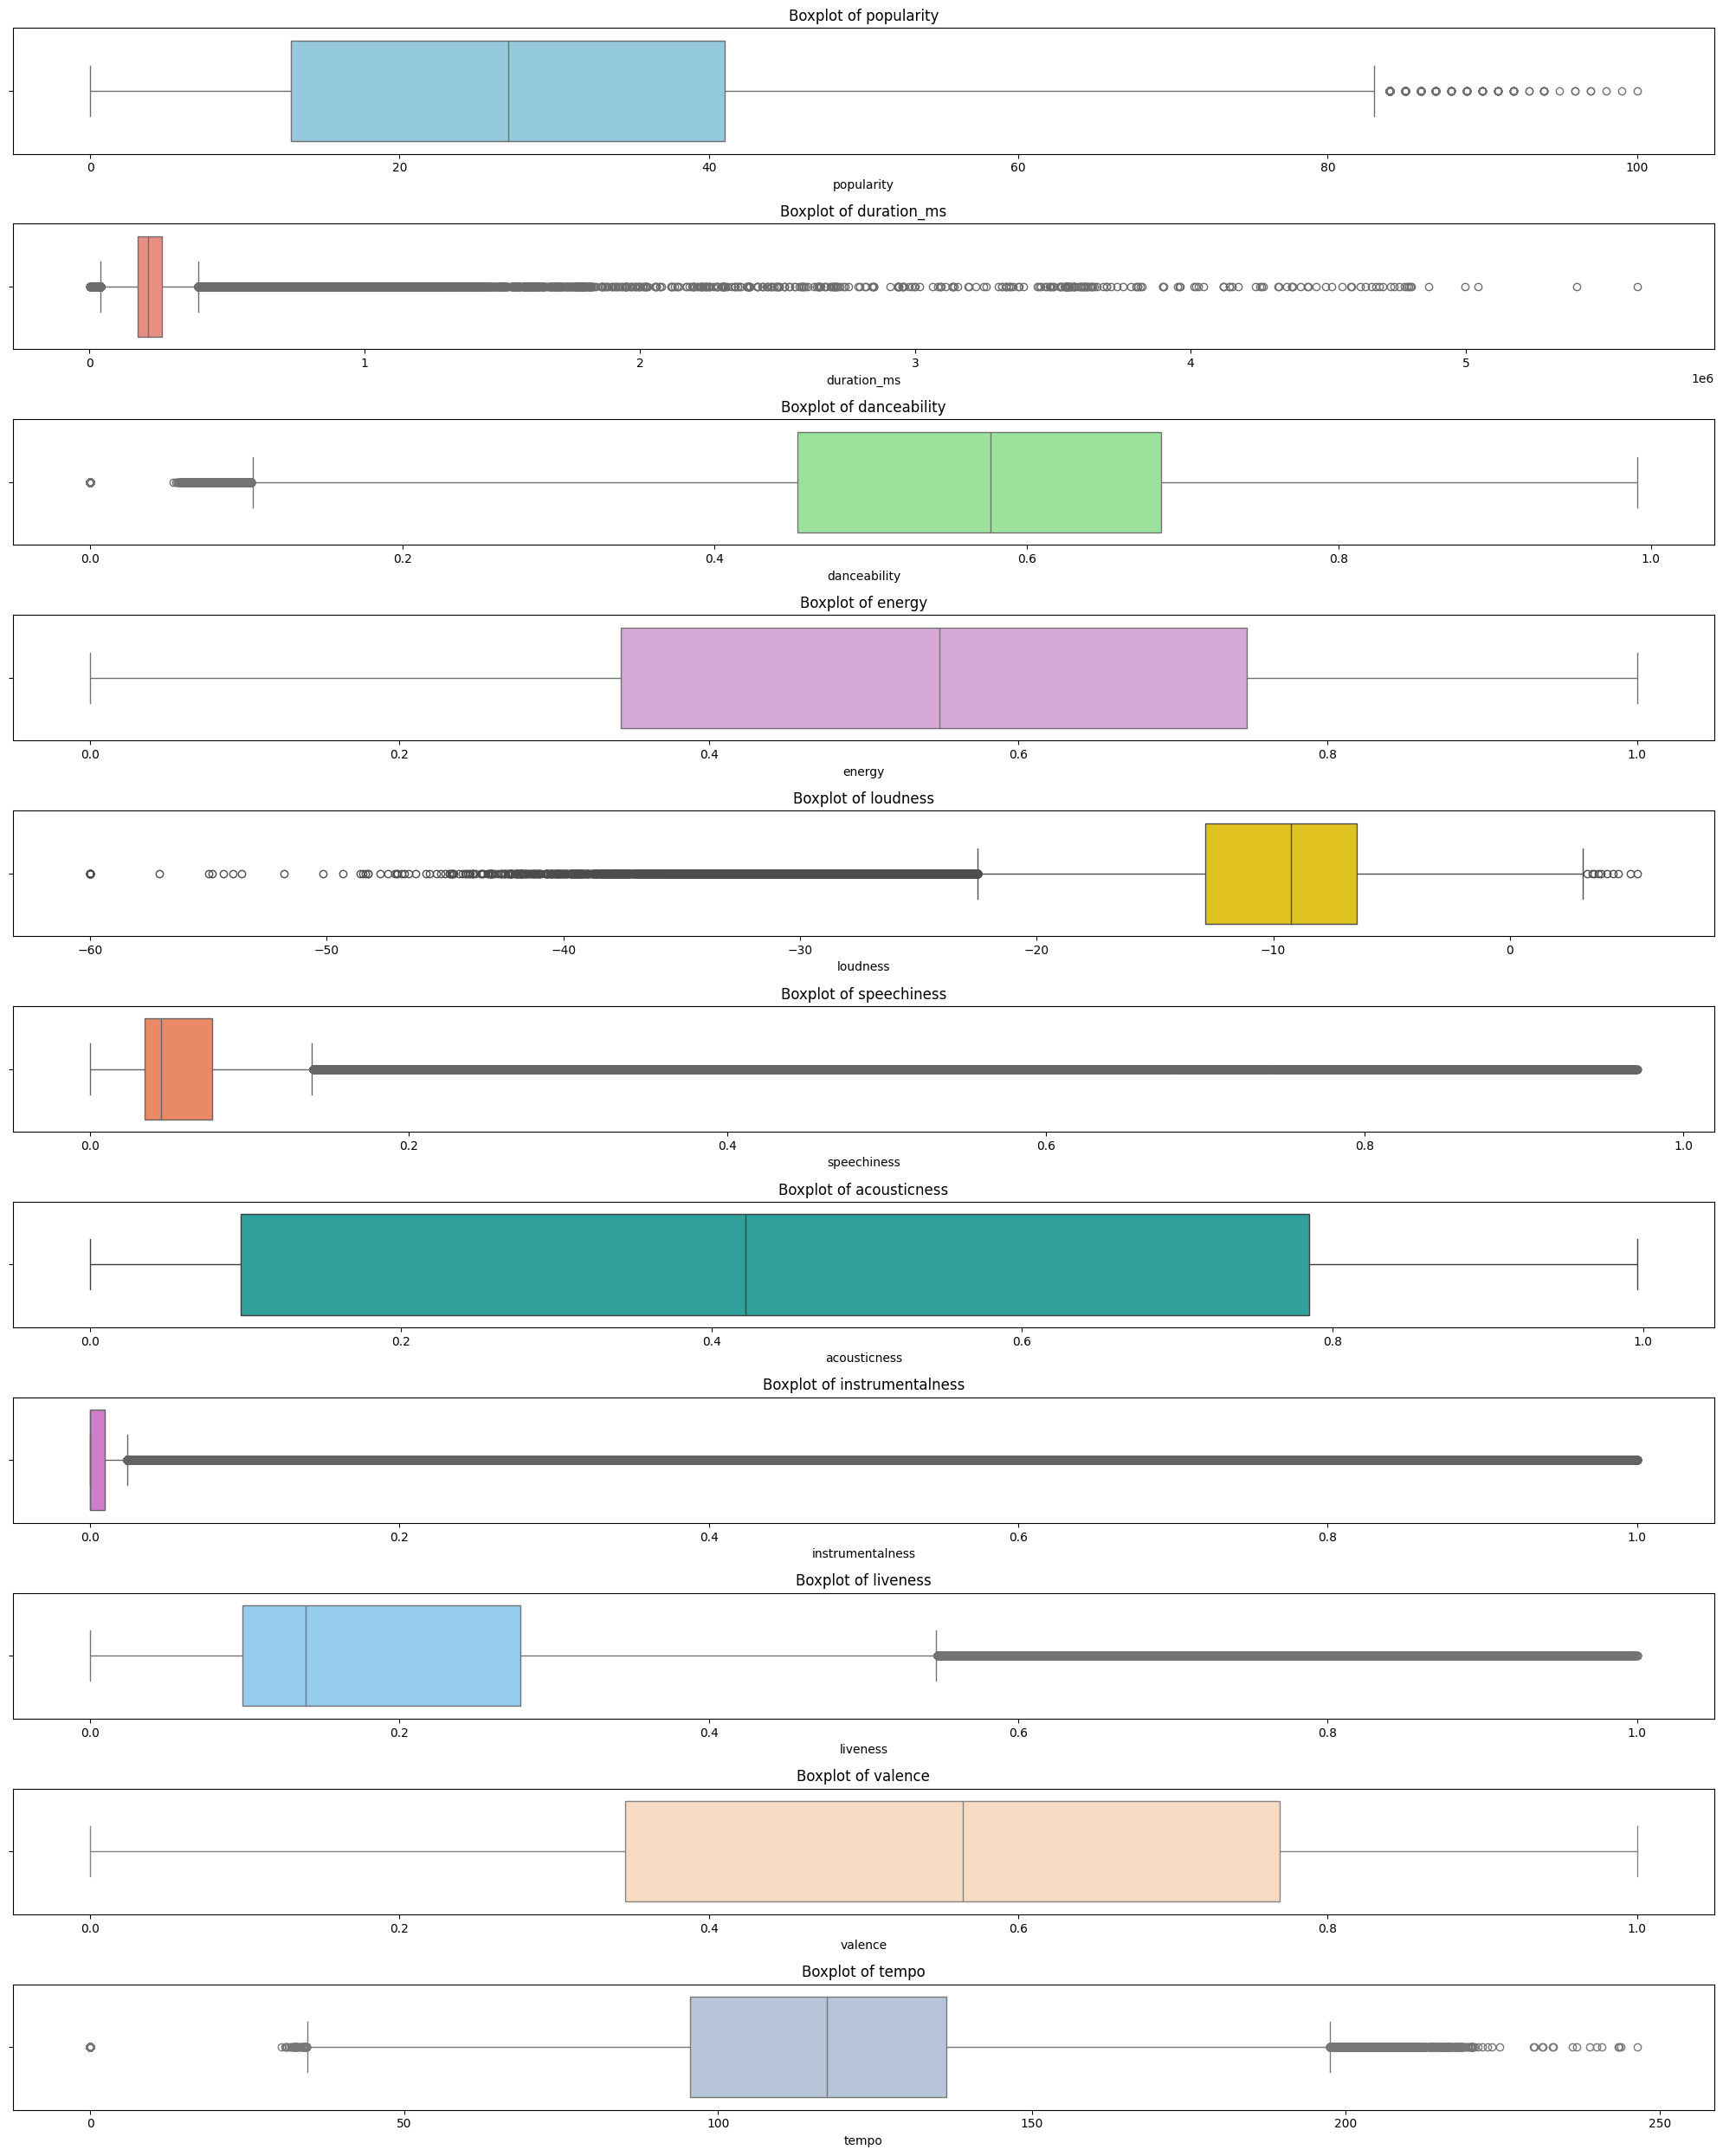

In [19]:
# List of numeric columns to visualize
num_cols = [
    'popularity', 'duration_ms', 'danceability', 'energy', 'loudness',
    'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'
]

# List of distinct colors
colors = [
    'skyblue', 'salmon', 'lightgreen', 'plum', 'gold', 
    'coral', 'lightseagreen', 'orchid', 'lightskyblue', 'peachpuff', 'lightsteelblue'
]

# Plot boxplots with different colors
plt.figure(figsize=(20, 25))
for i, (col, color) in enumerate(zip(num_cols, colors), 1):
    plt.subplot(len(num_cols), 1, i)
    sns.boxplot(x=df_tr[col], color=color)
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [20]:
# Create seperate categories 
df_tr['popularity_level'] = pd.qcut(df_tr['popularity'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])
df_tr['danceability_level'] = pd.qcut(df_tr['danceability'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# I. Artist Popularity Trends & Genre Dominance

C:\Users\shali\AppData\Local\Temp\ipykernel_41648\2609299425.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='followers', y='name', data=top_followed, palette='cool')


Text(0.5, 1.0, 'Top 10 Most Followed Artists')

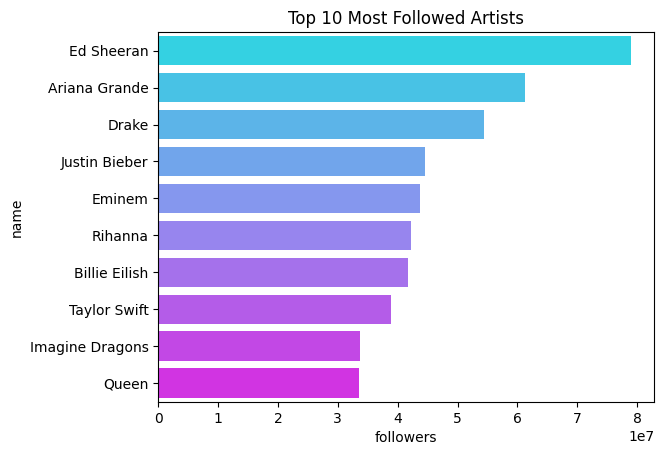

In [21]:
# a. Top 10 Most Followed Artists:

top_followed = df_ar[['name', 'followers']].sort_values(by='followers', ascending=False).head(10)
sns.barplot(x='followers', y='name', data=top_followed, palette='cool')
plt.title('Top 10 Most Followed Artists')

C:\Users\shali\AppData\Local\Temp\ipykernel_41648\2621383466.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='popularity', y='name', data=most_followed, palette='muted')


Text(0.5, 1.0, 'Top 10 Most Popular artists')

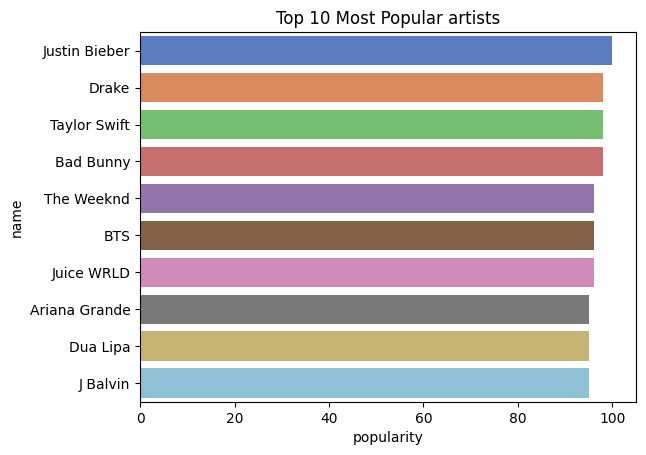

In [22]:
#  b. Top 10 Most Popular Artists:

most_followed = df_ar[['name', 'popularity']].sort_values(by='popularity', ascending=False).head(10)
sns.barplot(x='popularity', y='name', data=most_followed, palette='muted')
plt.title('Top 10 Most Popular artists')

✅ Sampled artists with >1000 followers


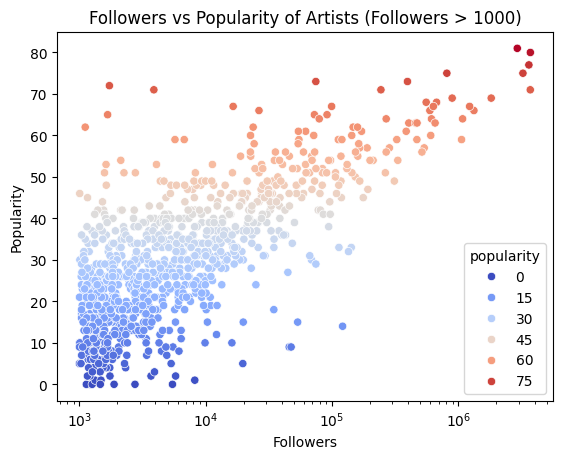

In [36]:
# c. Popularity vs Followers (Are they correlated?)

# Filter for artists with more than 1000 followers
filtered_df = df_ar[df_ar['followers'] > 1000][['followers', 'popularity']].dropna().sample(1000, random_state=42) 
# removed artists with 0-1000 followers as that gives a straight vertical plot 

print("✅ Sampled artists with >1000 followers")

sns.scatterplot(data=filtered_df, x='followers', y='popularity', hue='popularity',  palette='coolwarm')

plt.title('Followers vs Popularity of Artists (Followers > 1000)')
plt.xlabel('Followers')
plt.ylabel('Popularity')
plt.xscale('log')  # Used log scale for x-axis to handle large variation in follower counts (like 1k to 10M) better
plt.show()

# Insights : 

1. Top Followed Artist: Ed Sheeran leads the chart in follower count, indicating strong fan loyalty and long-term audience engagement.

2. Top Popular Artist: Justin Bieber tops the popularity list, showing high current engagement, though not necessarily the most followed.

3. Followers vs Popularity: While there's a positive correlation between followers and popularity, they don't always align. Some artists may be highly followed but less currently popular, and vice versa.

# II. Popularity and Energy Comparison — Explicit vs Clean Tracks

C:\Users\shali\AppData\Local\Temp\ipykernel_41648\668714156.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='explicit_label', y='popularity', data=df_tr, palette='rocket')


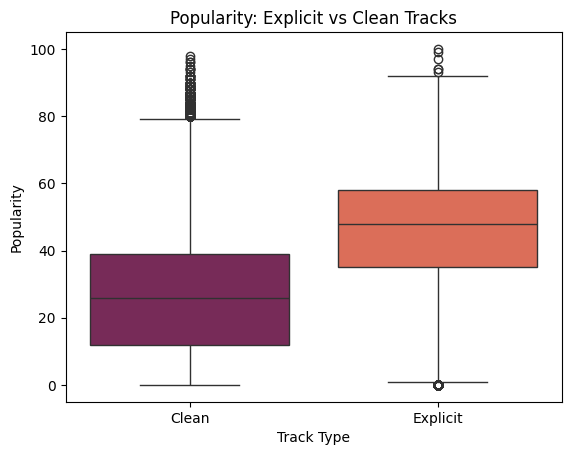

In [39]:
# a. Popularity based on tracks

# I will use the explicit_table that I made earlier

sns.boxplot(x='explicit_label', y='popularity', data=df_tr, palette='rocket')
plt.title('Popularity: Explicit vs Clean Tracks')
plt.xlabel('Track Type')
plt.ylabel('Popularity')
plt.show()

C:\Users\shali\AppData\Local\Temp\ipykernel_41648\1626789793.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='explicit_label', y='energy', data=df_tr, palette='Set3')


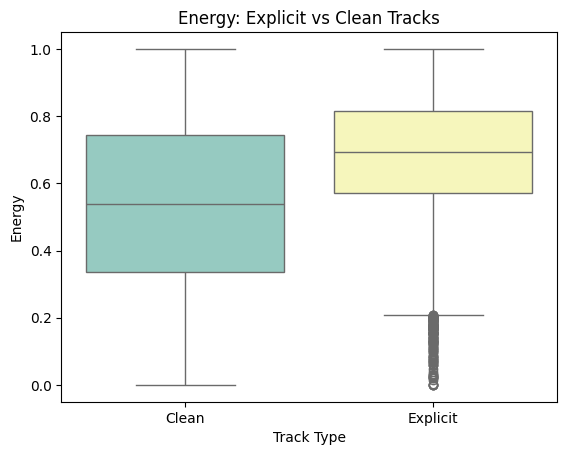

In [40]:
# b. Energy based on tracks

sns.boxplot(x='explicit_label', y='energy', data=df_tr, palette='Set3')
plt.title('Energy: Explicit vs Clean Tracks')
plt.xlabel('Track Type')
plt.ylabel('Energy')
plt.show()

# Conclusion : 

### For Popularity :

1.  Explicit tracks are more consistently popular, and the presence of high-popularity outliers suggests many viral or trending songs fall into this category.

2. Clean tracks show greater variation, with both low-performing and highly popular exceptions.

3. This suggests that while clean tracks are more common, explicit tracks dominate current trends in mainstream popularity.

4. Even though clean tracks are usually less popular overall, the presence of many high-end outliers indicates that some clean songs perform exceptionally well, pulling the average up, but also making the distribution less consistent compared to explicit tracks.


### For Energy : 

1. Explicit tracks are generally more energetic, reflecting intense, bold genres like rap or hip-hop.

2. But the presence of low-energy outliers suggests that explicit content spans diverse moods — from aggressive to calm.

3. Clean tracks are more uniform and energy-balanced, likely covering genres like pop, acoustic, or instrumental.

#  III. Genre & Era Evolution 

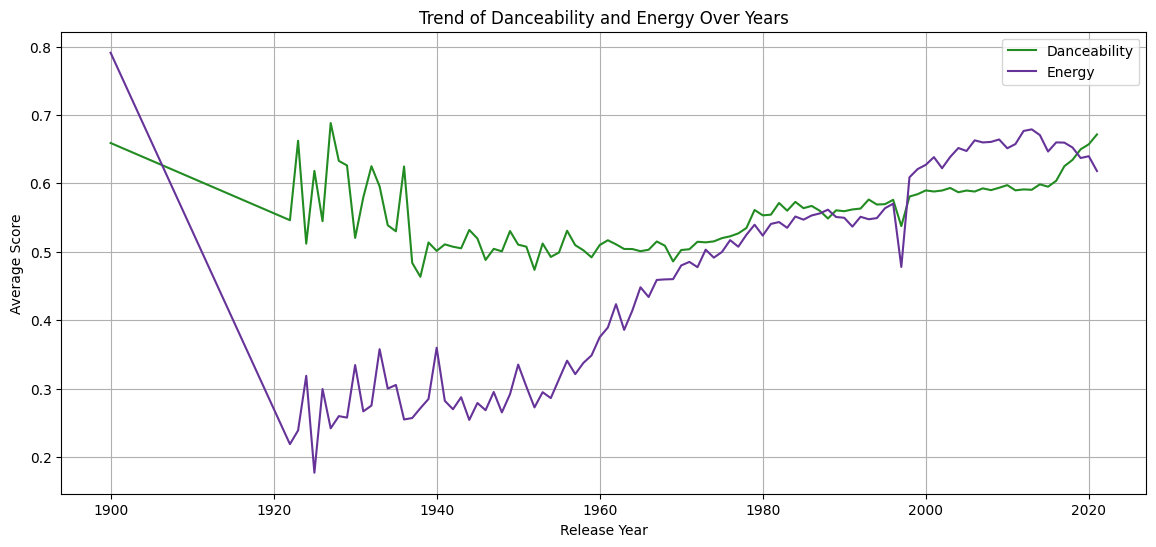

In [44]:
# I will use the release_year column that I made earlier

yearly_stats = df_tr.groupby('release_year')[['danceability', 'energy']].mean().reset_index()

plt.figure(figsize=(14, 6))

# Danceability over time
sns.lineplot(x='release_year', y='danceability', data=yearly_stats, label='Danceability', color='forestgreen')

# Energy over time
sns.lineplot(x='release_year', y='energy', data=yearly_stats, label='Energy', color='rebeccapurple')

plt.title('Trend of Danceability and Energy Over Years')
plt.xlabel('Release Year')
plt.ylabel('Average Score')
plt.legend()
plt.grid(True)
plt.show()

# Conclusion : 

1. Early Years (1920s) :

    a. Energy started very low, reflecting softer, acoustic music styles.

    b. Danceability was slightly higher but still not dominant, with noticeable fluctuations.
    

2. Mid-Century to 1980s :

    a. Danceability remained inconsistent, possibly due to varying music trends across decades.

    b. Energy saw a steady rise, gradually narrowing the gap with danceability.
    

3. Post-1980s Onward :
   
    a. Both features started to rise together, showing that newer tracks became both more danceable and more energetic.
   
    b. By 2000, energy overtook danceability, highlighting a shift toward high-intensity music genres like EDM, hip-hop, and electronic pop.

# IV. Audio Feature Correlations

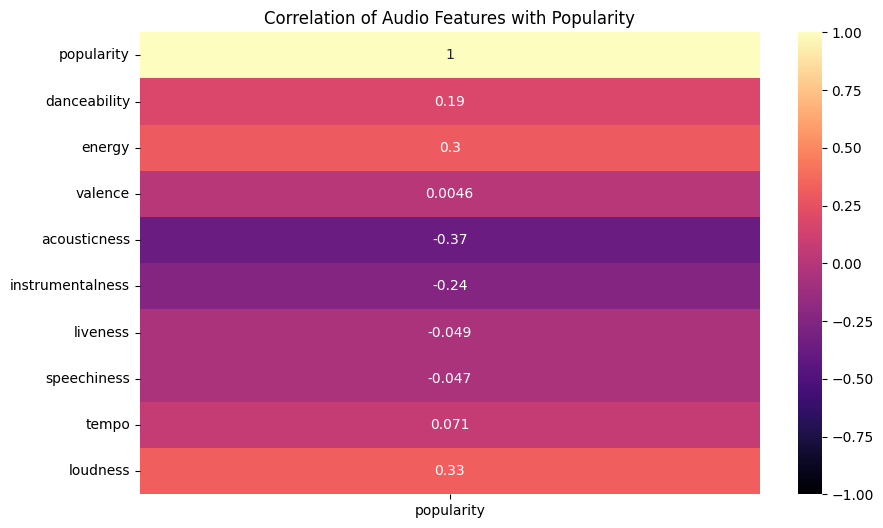

In [52]:
features = ['danceability', 'energy', 'valence', 'acousticness', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'loudness']

correlation_data = df_tr[['popularity'] + features].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_data[['popularity']], annot=True, cmap='magma', vmin=-1, vmax=1)
plt.title('Correlation of Audio Features with Popularity')
plt.show()

# Conclusion : 

1. Acousticness is Strongly Negative
→ Tracks with higher acousticness (more acoustic/softer sounds) tend to be less popular, showing a clear preference for modern, digitally produced music.

2. Loudness is Strongly Positive
→ Popular tracks are generally louder, suggesting that high production intensity and volume levels are linked to better listener engagement.

3. Danceability & Energy Show Mild Positive Correlation
→ While not as strong, more energetic and danceable songs tend to attract more listeners, aligning with current upbeat music trends.

4. Liveness & Speechiness Have Weak Correlations
→ Features like liveness (presence of an audience) and speechiness (spoken words) show low or slightly negative influence, meaning they have minimal impact on popularity overall.

# V. Genre Specific Analysis : Do different genres prioritize different audio features?

C:\Users\shali\AppData\Local\Temp\ipykernel_41648\1148019350.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_popularity.values, y=genre_popularity.index, palette="magma")


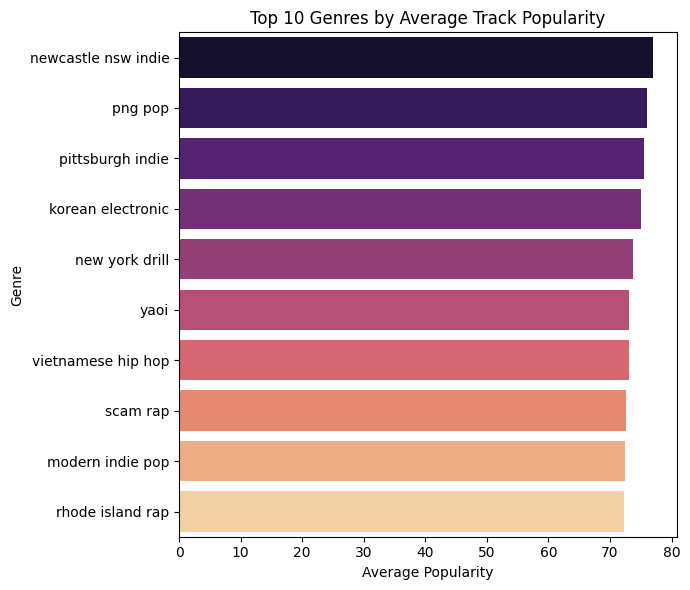

In [66]:
df_merged = pd.merge(
    df_tr,
    df_ar[['id', 'genres']],
    left_on='main_artist_id',
    right_on='id',
    how='left'
)
import ast
df_merged['genres'] = df_merged['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# Keep only valid genre lists
df_merged = df_merged[df_merged['genres'].apply(lambda x: isinstance(x, list) and len(x) > 0)]

# Explode genres
df_exploded = df_merged.explode('genres')

genre_popularity = df_exploded.groupby('genres')['popularity'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(7,6))
sns.barplot(x=genre_popularity.values, y=genre_popularity.index, palette="magma")
plt.title("Top 10 Genres by Average Track Popularity")
plt.xlabel("Average Popularity")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

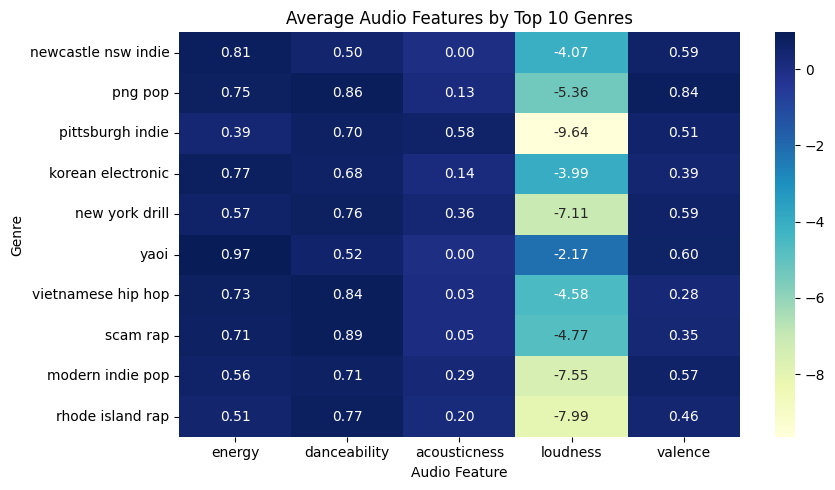

In [70]:
features = ['energy', 'danceability', 'acousticness', 'loudness', 'valence']
genre_features = df_exploded.groupby('genres')[features].mean()

top_genres_list = genre_popularity.index.tolist()
genre_features_top = genre_features.loc[top_genres_list]

plt.figure(figsize=(9, 5))
sns.heatmap(genre_features_top, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Average Audio Features by Top 10 Genres")
plt.ylabel("Genre")
plt.xlabel("Audio Feature")
plt.tight_layout()
plt.show()

# Conclusion : 

1. All top genres exhibit positive values for features like energy, danceability, and valence — indicating upbeat and emotionally engaging tracks across genres.

2. Loudness is consistently negative, which is expected since it's measured in decibels (dB); more negative means softer sounds. Genres like Yaoi may still feel energetic but are not necessarily the loudest.

3. Acousticness is relatively lower than energy, danceability, and valence — suggesting that most popular genres favor digital or electronic sounds over purely acoustic instrumentation.

# VI. Artist-Level Audio Profiles

C:\Users\shali\AppData\Local\Temp\ipykernel_41648\2938751879.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='name', x='energy', data=top_artists, palette='rocket')
C:\Users\shali\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38646 (\N{CJK UNIFIED IDEOGRAPH-96F6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\shali\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\shali\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20061 (\N{CJK UNIFIED IDEOGRAPH-4E5D}) missing from font(s) DejaVu Sans.
  f

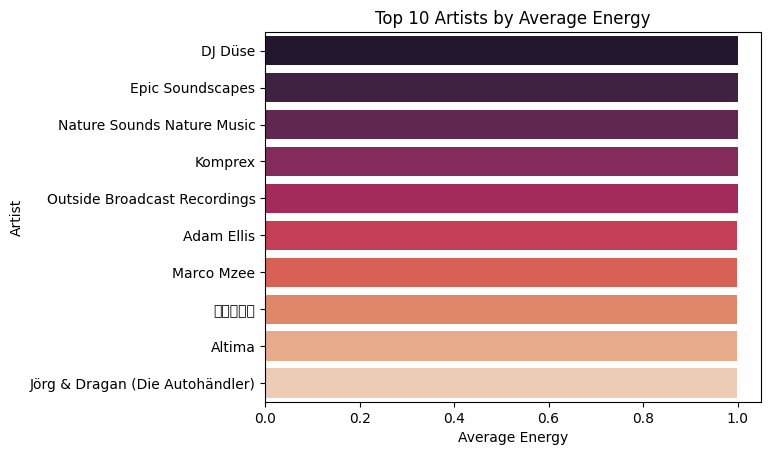

In [74]:
artist_audio = df_merged.groupby('main_artist_id')[['energy', 'danceability', 'acousticness']].mean().reset_index()
artist_audio = pd.merge(artist_audio, df_ar[['id', 'name']], left_on='main_artist_id', right_on='id', how='left')
top_artists = artist_audio.sort_values(by='energy', ascending=False).head(10)

sns.barplot(y='name', x='energy', data=top_artists, palette='rocket')
plt.title('Top 10 Artists by Average Energy')
plt.xlabel('Average Energy')
plt.ylabel('Artist')
plt.show()

# VII. Detect Outlier Tracks Based on Popularity

Total outlier tracks (popularity > 3σ): 442


C:\Users\shali\AppData\Local\Temp\ipykernel_41648\2497292518.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='outlier', y='popularity', data=df_tr, palette='dark')


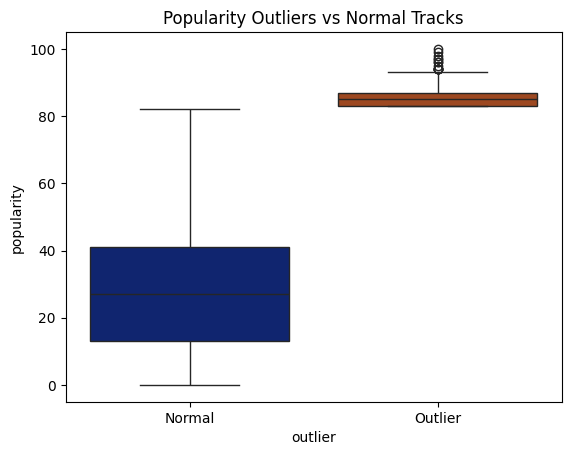

In [73]:
from scipy import stats

# Z-score method for popularity
z_scores = stats.zscore(df_tr['popularity'])
df_tr['popularity_z'] = z_scores
outliers = df_tr[np.abs(z_scores) > 3]  # z > 3 = outlier
print(f"Total outlier tracks (popularity > 3σ): {len(outliers)}")

df_tr['outlier'] = np.where(np.abs(df_tr['popularity_z']) > 3, 'Outlier', 'Normal')
sns.boxplot(x='outlier', y='popularity', data=df_tr, palette='dark')
plt.title('Popularity Outliers vs Normal Tracks')
plt.show()


# Conclusion : 

1. Most tracks have popularity between 30–40, showing moderate success.

2. A thin box around 80–85 suggests very few tracks consistently reach high popularity.

3. Outliers (90–100) indicate exceptional hits—rare tracks that stand out sharply.